In [1]:
import os
import pathlib

import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,Resizing,Input,Normalization
from keras import models
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib widget

from IPython import display #برای گوش کردن به صدای رکورد شده ست

In [4]:
DATASET_PATH = 'D:\AI\\aiolearn\deep learning\9\data/'

data_dir = pathlib.Path(DATASET_PATH)


tf.keras.utils.get_file(
    'voicedataset.zip',
    origin="http://aiolearn.com/dl/datasets/voicedata.zip",
    extract=True,
    cache_dir='.', cache_subdir='data')

print("DONE!")

DONE!


In [5]:
tf.io.gfile.listdir(str(data_dir))

['down',
 'go',
 'left',
 'no',
 'README.md',
 'right',
 'stop',
 'up',
 'voicedataset.zip',
 'yes']

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'voicedataset.zip')]
print('Commands Available:', commands)

Commands Available: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2, #همون تست دیتا
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(X_train.class_names)
print()
print("label :", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label : ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test= X_test.map(squeeze, tf.data.AUTOTUNE)

In [9]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [11]:
val=X_test
X_test = X_test.shard(num_shards=2, index=0)
val = X_test.shard(num_shards=2, index=1)

In [12]:
for x, y in X_train.take(1):  
  print(x)
  print(label_names[y])

tf.Tensor(
[[ 3.0517578e-05  1.2207031e-04  1.2207031e-04 ...  9.1552734e-05
   1.5258789e-04  1.5258789e-04]
 [-6.1035156e-05 -6.1035156e-05  9.1552734e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.5869141e-03 -2.9907227e-03 -1.1993408e-02 ... -1.8646240e-02
  -1.4373779e-02 -8.0566406e-03]
 ...
 [ 1.8310547e-04  3.6621094e-04  3.3569336e-04 ...  3.0517578e-05
  -2.7465820e-04 -4.5776367e-04]
 [ 1.2207031e-04  5.7983398e-04 -3.9672852e-04 ... -5.7983398e-04
  -3.6621094e-04 -3.9672852e-04]
 [-1.0681152e-03 -5.1879883e-03 -8.6059570e-03 ...  5.6152344e-03
   9.0332031e-03  1.6326904e-02]], shape=(64, 16000), dtype=float32)
['right' 'up' 'no' 'no' 'up' 'stop' 'go' 'no' 'down' 'yes' 'no' 'down'
 'left' 'down' 'right' 'up' 'right' 'stop' 'go' 'no' 'go' 'down' 'down'
 'stop' 'down' 'left' 'go' 'yes' 'stop' 'left' 'no' 'stop' 'up' 'yes'
 'right' 'no' 'go' 'go' 'left' 'stop' 'stop' 'no' 'down' 'go' 'right'
 'stop' 'no' 'stop' 'down' 'right' 'down' 'stop' 'left' 'no' 'no' 'up'


In [13]:
for example_audio, example_labels in X_train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [14]:
label_names[[0,1,2]]

array(['down', 'go', 'left'], dtype='<U5')

In [15]:
example_audio[0][5100]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0014343262>

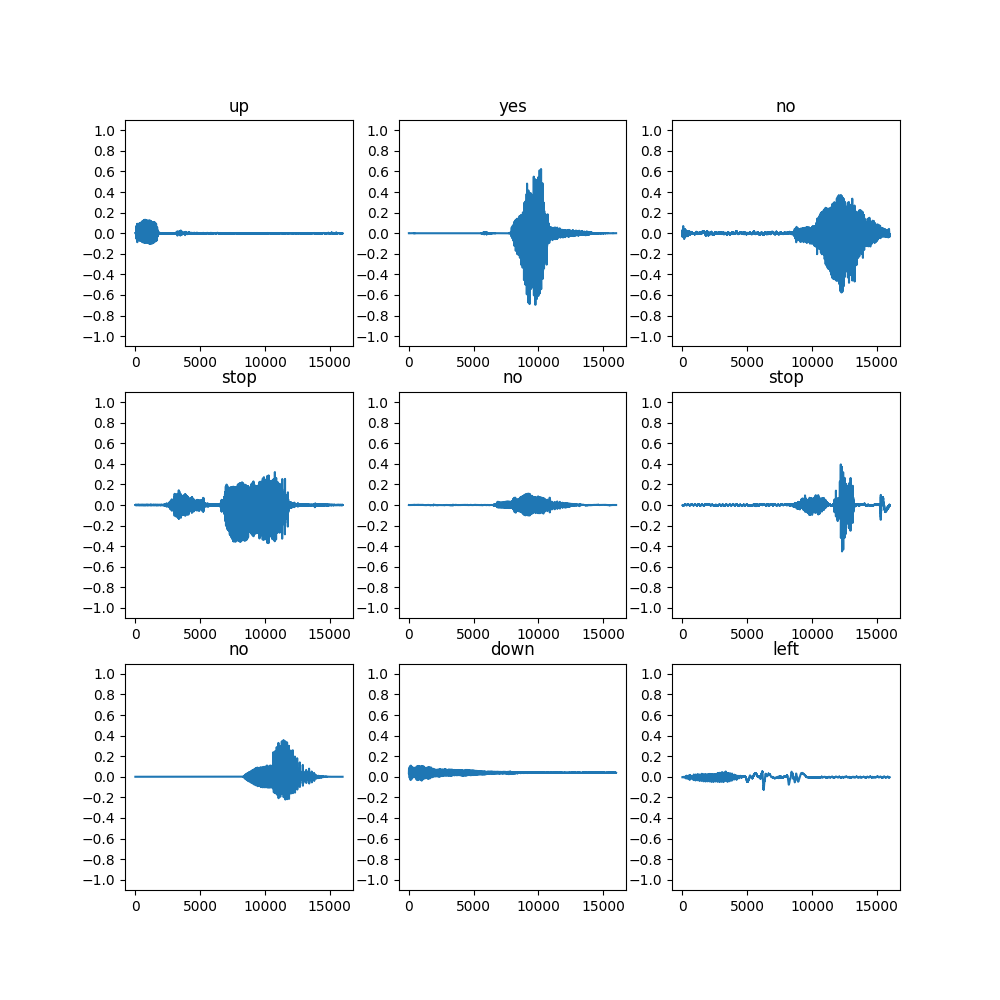

In [16]:
plt.figure(figsize=(10, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [17]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [18]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [19]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1) 
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

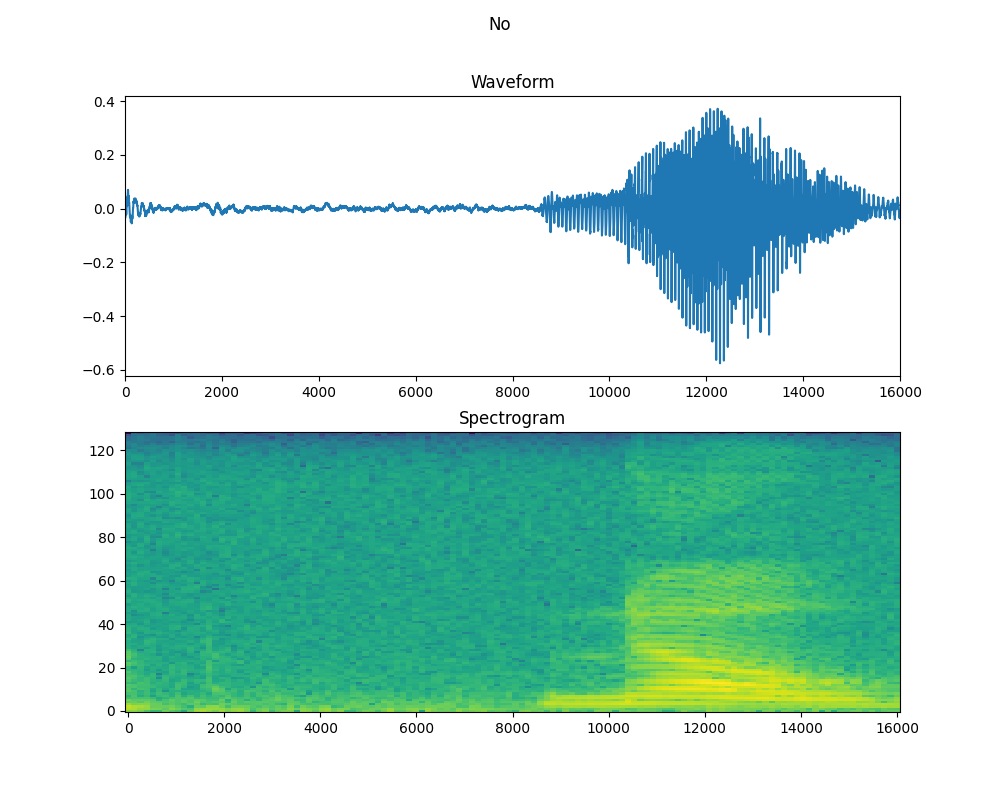

In [20]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [21]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_spectrogram_ds = make_spec_ds(X_train)
val_spectrogram_ds = make_spec_ds(val)
test_spectrogram_ds = make_spec_ds(X_test)

In [24]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

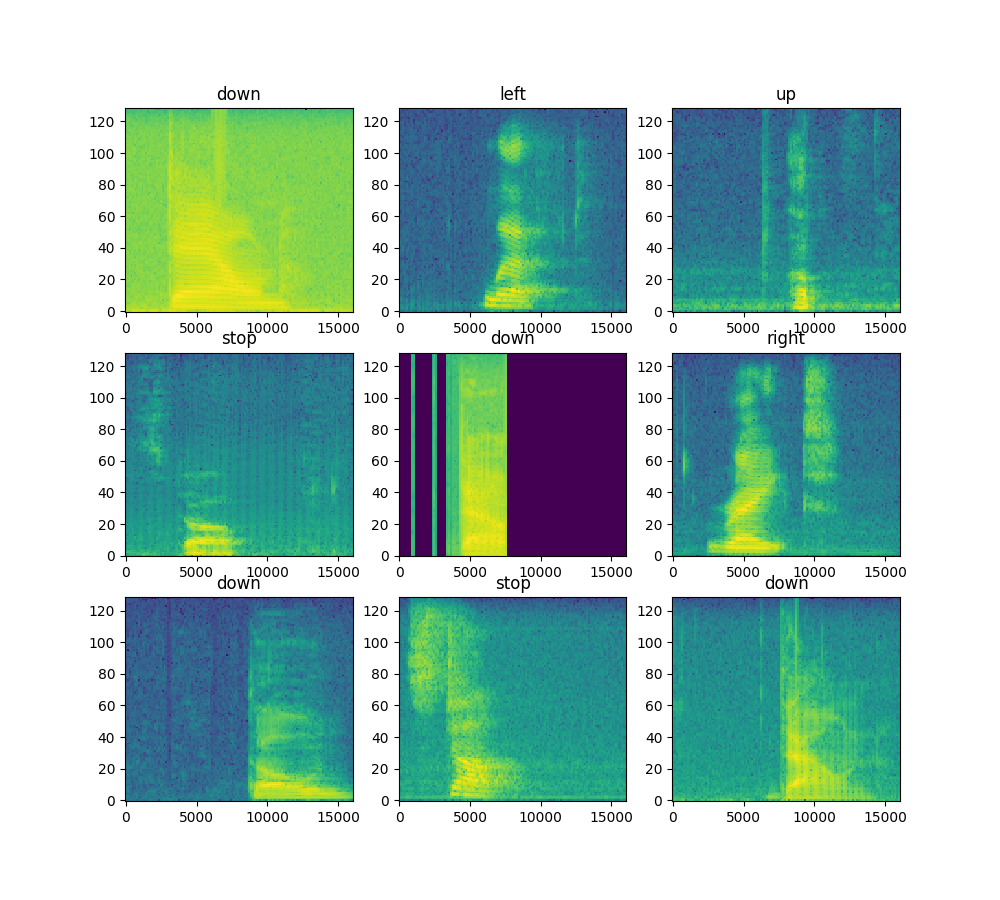

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [26]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [27]:
example_spectrograms.shape[1:]

TensorShape([124, 129, 1])

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
 
norm_layer = Normalization() 
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 6s 51ms/step - loss: 1.7655 - accuracy: 0.3655 - val_loss: 1.3404 - val_accuracy: 0.5833
Epoch 2/10
100/100 [==============================] - 4s 39ms/step - loss: 1.2025 - accuracy: 0.5786 - val_loss: 0.9693 - val_accuracy: 0.6797
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.9096 - accuracy: 0.6802 - val_loss: 0.7853 - val_accuracy: 0.7214
Epoch 4/10
100/100 [==============================] - 4s 37ms/step - loss: 0.7501 - accuracy: 0.7322 - val_loss: 0.6624 - val_accuracy: 0.7292
Epoch 5/10
100/100 [==============================] - 4s 37ms/step - loss: 0.6308 - accuracy: 0.7727 - val_loss: 0.6065 - val_accuracy: 0.7786
Epoch 6/10
100/100 [==============================] - 4s 38ms/step - loss: 0.5446 - accuracy: 0.8073 - val_loss: 0.5834 - val_accuracy: 0.7865
Epoch 7/10
100/100 [==============================] - 4s 38ms/step - loss: 0.4772 - accuracy: 0.8364 - val_loss: 0.5615 - val_accuracy: 0.7969

Text(0, 0.5, 'Accuracy [%]')

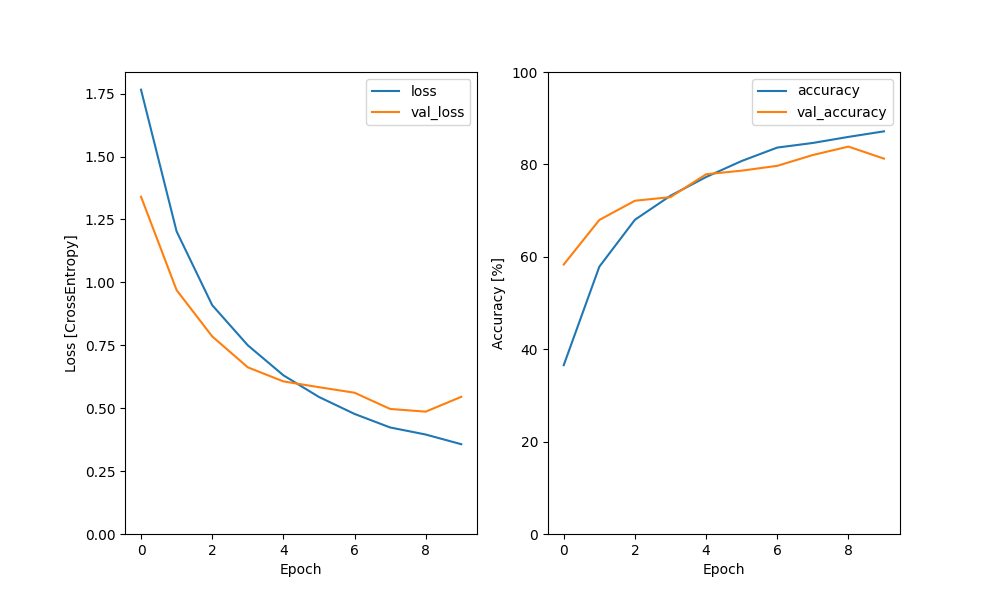

In [32]:
metrics = history.history
plt.close()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [33]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 23ms/step - loss: 0.5123 - accuracy: 0.8269


{'loss': 0.5122863054275513, 'accuracy': 0.8269230723381042}

In [34]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 9ms/step


In [35]:
y_pred = tf.argmax(y_pred, axis=1)

In [36]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

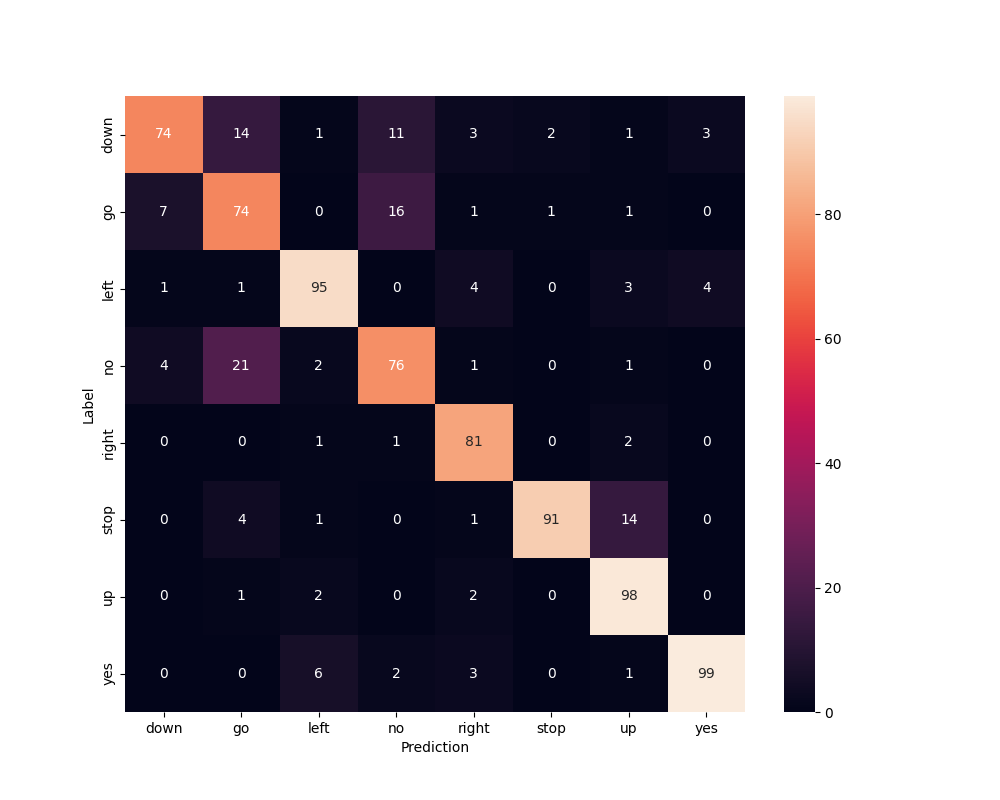

In [37]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

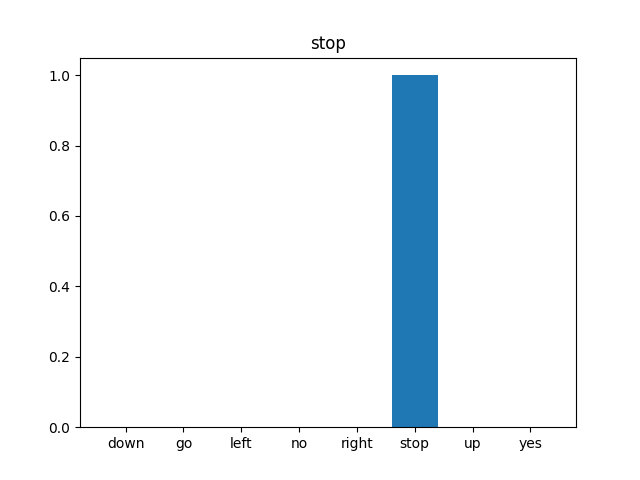

In [39]:
import IPython.display
 
x = data_dir/'stop/1c45ceb2_nohash_1.wav'
x = tf.io.read_file(str(x))


plt.close()

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('stop')
plt.show()

display.display(display.Audio(waveform, rate=16000,autoplay=True))

In [40]:
import IPython.display
 
x = 'data/stop/8a28231e_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
display.display(display.Audio(waveform, rate=16000,autoplay=True))

In [41]:
IPython.__version__

'8.12.3'

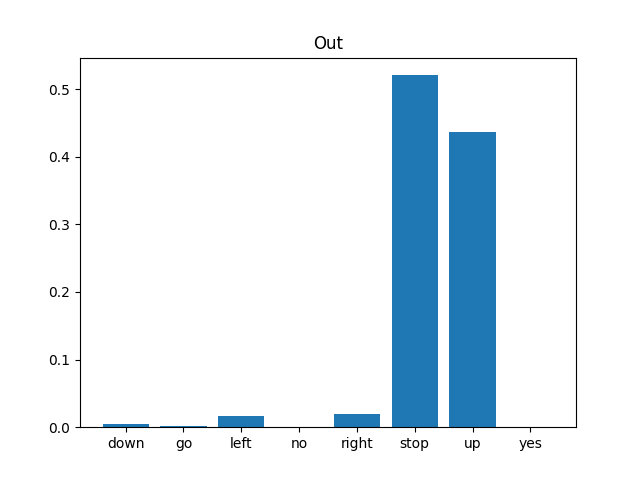

In [49]:
import pyaudio
p = pyaudio.PyAudio()
sabad=16000
stream = p.open(format=pyaudio.paInt16, channels=1, rate=16000,input=True,frames_per_buffer=sabad )
a=stream.read(sabad)

import wave
wf = wave.open("majid.wav", 'wb')
wf.setnchannels(1)
wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
wf.setframerate(16000 )
wf.writeframes(b''.join([a]))
wf.close()

x = 'majid.wav'
x = tf.io.read_file(str(x))
 

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.close()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Out')
plt.show()
 

In [106]:
model.save_weights('model.h5')